# Seq2Seq: Encoder-Decoder Chatbot 

![](https://cdn-images-1.medium.com/max/2560/1*1I2tTjCkMHlQ-r73eRn4ZQ.png)

In [0]:
import numpy as np
import pandas as pd
import string
import pickle
import operator
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1. Import Data

In [0]:
# .txtから会話データを取得する
import codecs

with codecs.open("movie_lines.txt", "rb", encoding="utf-8", errors="ignore") as f:
    lines = f.read().split("\n")
    conversations = []
    for line in lines:
        data = line.split(" +++$+++ ")
        conversations.append(data)

In [7]:
conversations[:6]

[['L1045', 'u0', 'm0', 'BIANCA', 'They do not!'],
 ['L1044', 'u2', 'm0', 'CAMERON', 'They do to!'],
 ['L985', 'u0', 'm0', 'BIANCA', 'I hope so.'],
 ['L984', 'u2', 'm0', 'CAMERON', 'She okay?'],
 ['L925', 'u0', 'm0', 'BIANCA', "Let's go."],
 ['L924', 'u2', 'm0', 'CAMERON', 'Wow']]

In [0]:
# idと会話だけ取り出す
chats = {}
for tokens in conversations:
    if len(tokens) > 4:
        idx = tokens[0][1:]
        chat = tokens[4]
        chats[int(idx)] = chat

In [ ]:
# idと会話をセットにする
sorted_chats = sorted(chats.items(), key = lambda x: x[0])
sorted_chats

In [0]:
# 会話のペアごとに辞書を作る { 会話セットid: [会話リスト] }
conves_dict = {}
counter = 1
conves_ids = []
for i in range(1, len(sorted_chats)+1):
    if i < len(sorted_chats):
        if (sorted_chats[i][0] - sorted_chats[i-1][0]) == 1:
            # 1つ前の会話の頭の文字がないのを確認
            if sorted_chats[i-1][1] not in conves_ids:
                conves_ids.append(sorted_chats[i-1][1])
            conves_ids.append(sorted_chats[i][1])
        elif (sorted_chats[i][0] - sorted_chats[i-1][0]) > 1:            
            conves_dict[counter] = conves_ids
            conves_ids = []
        counter += 1
    else:
        pass

In [ ]:
conves_dict

In [0]:
context_and_target = []
for conves in conves_dict.values():
    # ペアがない会話は捨てる
    if len(conves) % 2 != 0:
        conves = conves[:-1]
    for i in range(0, len(conves), 2):
        context_and_target.append((conves[i], conves[i+1]))

In [14]:
# ペア完成
context_and_target[:5]

[('Did you change your hair?', 'No.'),
 ('I missed you.',
  'It says here you exposed yourself to a group of freshmen girls.'),
 ('It was a bratwurst.  I was eating lunch.',
  'With the teeth of your zipper?'),
 ('You the new guy?', 'So they tell me...'),
 ("C'mon.  I'm supposed to give you the tour.",
  'So -- which Dakota you from?')]

In [0]:
context, target = zip(*context_and_target)

In [0]:
context = list(context)
target = list(target)

In [17]:
context[:5]

['Did you change your hair?',
 'I missed you.',
 'It was a bratwurst.  I was eating lunch.',
 'You the new guy?',
 "C'mon.  I'm supposed to give you the tour."]

In [18]:
target[:20]

['No.',
 'It says here you exposed yourself to a group of freshmen girls.',
 'With the teeth of your zipper?',
 'So they tell me...',
 'So -- which Dakota you from?',
 'I was kidding. People actually live there?',
 'How many people were in your old school?',
 'Get out!',
 'Couple thousand. Most of them evil',
 'Yeah, but these guys have never seen a horse.  They just jack off to Clint Eastwood.',
 'You burn, you pine, you perish?',
 "Bianca Stratford.  Sophomore. Don't even think about it",
 "I could start with your haircut, but it doesn't matter.  She's not allowed to date until her older sister does.  And that's an impossibility.",
 'Expressing my opinion is not a terrorist action.',
 'I still maintain that he kicked himself in the balls.  I was merely a spectator.',
 'Tempestuous?',
 'Patrick Verona   Random skid.',
 "I'm sure he's completely incapable of doing anything that interesting.",
 'Block E?',
 'Just a little.']

## Step 2. Preprocessing for text data

In [0]:
# from my_seq2seq_text_cleanear import text_modifier, nonalpha_remover
import re
MAX_LEN = 12

In [173]:
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    
    return text

### 2-1. Clean Text

In [0]:
tidy_target = []
for conve in target:
    text = clean_text(conve)
    tidy_target.append(text)

In [22]:
tidy_target[:20]

['no',
 'it says here you exposed yourself to a group of freshmen girls',
 'with the teeth of your zipper',
 'so they tell me',
 'so  which dakota you from',
 'i was kidding people actually live there',
 'how many people were in your old school',
 'get out',
 'couple thousand most of them evil',
 'yeah but these guys have never seen a horse  they just jack off to clint eastwood',
 'you burn you pine you perish',
 'bianca stratford  sophomore do not even think about it',
 'i could start with your haircut but it does not matter  she is not allowed to date until her older sister does  and that is an impossibility',
 'expressing my opinion is not a terrorist action',
 'i still maintain that he kicked himself in the balls  i was merely a spectator',
 'tempestuous',
 'patrick verona   random skid',
 'i am sure he is completely incapable of doing anything that interesting',
 'block e',
 'just a little']

In [0]:
tidy_context = []
for conve in context:
    text = clean_text(conve)
    tidy_context.append(text)

In [24]:
tidy_context[:20]

['did you change your hair',
 'i missed you',
 'it was a bratwurst  i was eating lunch',
 'you the new guy',
 "c'mon  i am supposed to give you the tour",
 'north actually  how would you   ',
 'yeah  a couple  we are outnumbered by the cows though',
 'thirtytwo',
 'how many people go here',
 'that i am used to',
 'that girl  i ',
 'who is she',
 'why not',
 'katarina stratford  my my  you have been terrorizing ms blaise again',
 "well yes compared to your other choices of expression this year today's events are quite mild  by the way bobby rictor's gonad retrieval operation went quite well in case you are interested",
 'the point is kat  people perceive you as somewhat ',
 "who's that",
 'that is pat verona the one who was gone for a year i heard he was doing porn movies',
 'he always look so',
 'mandella eat  starving yourself is a very slow way to die']

In [0]:
# decoderのinputには<BOS>と<EOS>タグ
bos = "<BOS> "
eos = " <EOS>"
final_target = [bos + conve + eos for conve in tidy_target] 
encoder_inputs = tidy_context
decoder_inputs = final_target

In [4]:
import codecs
with codecs.open("encoder_inputs.txt", "rb", encoding="utf-8", errors="ignore") as f:
    lines = f.read().split("\n")
    encoder_text = []
    for line in lines:
        data = line.split("\n")[0]
        encoder_text.append(data)

In [51]:
len(encoder_text)

143865

In [ ]:
encoder_text

In [6]:
with codecs.open("decoder_inputs.txt", "rb", encoding="utf-8", errors="ignore") as f:
    lines = f.read().split("\n")
    decoder_text = []
    for line in lines:
        data = line.split("\n")[0]
        decoder_text.append(data)

In [ ]:
decoder_text

### 2-2. MAKE VOCABRALY

In [0]:
# 一旦もともと辞書サイズを調べる
dictionary = []
for text in full_text:
    words = text.split()
    for i in range(0, len(words)):
        if words[i] not in dictionary:
            dictionary.append(words[i])

In [8]:
from keras.preprocessing.text import Tokenizer
VOCAB_SIZE = 14999
tokenizer = Tokenizer(num_words=VOCAB_SIZE)

Using TensorFlow backend.


In [9]:
full_text = encoder_text + decoder_text

In [10]:
# 辞書を作る
tokenizer.fit_on_texts(full_text)
word_index = tokenizer.word_index
len(word_index)

65283

In [66]:
# リバースした辞書を用意
index2word = {}
for k, v in word_index.items():
    if v < 15000:
        index2word[v] = k
    if v > 15000:
        continue

In [ ]:
index2word

In [68]:
word2index = {}
for k, v in index2word.items():
    word2index[v] = k

In [ ]:
word2index

In [71]:
len(word2index) == len(index2word)

True

In [70]:
len(index2word)

14999

### 2-3. ONE-HOT VECTORIZER

In [13]:
# 単語のシーケンスを作る np.arrayにする
encoder_sequences = tokenizer.texts_to_sequences(encoder_text)
# encider_sequences = np.array(encider_sequences)

In [14]:
# デコーダーデータ
decoder_sequences = tokenizer.texts_to_sequences(decoder_text)
# decoder_sequences = np.array(decoder_sequences)

In [ ]:
encoder_sequences

In [16]:
for seqs in encoder_sequences:
    for seq in seqs:
        if seq > 14999:
            print(seq)
            break

In [139]:
VOCAB_SIZE = len(index2word) + 1
VOCAB_SIZE

15000

In [53]:
decoder_output_data.shape

(143865, 20, 15000)

In [ ]:
decoder_sequences

In [98]:
import numpy as np
MAX_LEN = 20
num_samples = len(encoder_sequences)
decoder_output_data = np.zeros((num_samples, MAX_LEN, VOCAB_SIZE), dtype="float32")

In [130]:
# outputの３Dテンソル
for i, seqs in enumerate(decoder_input_data):
    for j, seq in enumerate(seqs):
        if j > 0:
            decoder_output_data[i][j][seq] = 1.

In [134]:
decoder_output_data.shape

(143865, 20, 15000)

### 2-4. PADDING

In [128]:
from keras.preprocessing.sequence import pad_sequences
encoder_input_data = pad_sequences(encoder_sequences, maxlen=MAX_LEN, dtype='int32', padding='post', truncating='post')
decoder_input_data = pad_sequences(decoder_sequences, maxlen=MAX_LEN, dtype='int32', padding='post', truncating='post')

In [129]:
decoder_input_data[0]

array([ 1, 32,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32)

### 2-5. Word2Vec: pretrained glove vector

In [57]:
embeddings_index = {}
with open('glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print("Glove Loded!")

Glove Loded!


In [59]:
embedding_dimention = 50
def embedding_matrix_creater(embedding_dimention, word_index):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimention))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [137]:
embedding_matrix = embedding_matrix_creater(50, word_index=word2index)

In [140]:
embed_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=50, trainable=True,)
embed_layer.build((None,))
embed_layer.set_weights([embedding_matrix])

## Step 3. Build Seq2Seq Model

In [60]:
from keras.layers import Embedding
from keras.layers import Input, Dense, LSTM, TimeDistributed
from keras.models import Model

In [149]:
def seq2seq_model_builder(HIDDEN_DIM=300):
    
    encoder_inputs = Input(shape=(MAX_LEN, ), dtype='int32',)
    encoder_embedding = embed_layer(encoder_inputs)
    encoder_LSTM = LSTM(HIDDEN_DIM, return_state=True)
    encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
    
    decoder_inputs = Input(shape=(MAX_LEN, ), dtype='int32',)
    decoder_embedding = embed_layer(decoder_inputs)
    decoder_LSTM = LSTM(HIDDEN_DIM, return_state=True, return_sequences=True)
    decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c])
    
    # dense_layer = Dense(VOCAB_SIZE, activation='softmax')
    outputs = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax'))(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], outputs)
    
    return model

In [150]:
model = seq2seq_model_builder(HIDDEN_DIM=300)

In [151]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 20, 50)       750000      input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lstm_11 (LSTM)                  [(None, 300), (None, 421200      embedding_3[8][0]                
__________

In [155]:
pwd

'/Users/akr712/Desktop/CHATBOT'

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='/Users/akr712/Desktop/CHATBOT/seq2seq.png')

In [154]:
model.compile(optimizer='adam', loss ='categorical_crossentropy', metrics = ['accuracy'])

## Step 4. Training Model

In [164]:
BATCH_SIZE = 32
EPOCHS = 5

In [163]:
encoder_input_data.shape

(143865, 20)

In [165]:
history = model.fit([encoder_input_data, decoder_input_data], 
                     decoder_output_data, 
                     epochs=EPOCHS, 
                     batch_size=BATCH_SIZE)

Epoch 1/5
143865/143865 [==============================] - 5913s 41ms/step - loss: 0.9308 - acc: 0.8280
Epoch 2/5
143865/143865 [==============================] - 5848s 41ms/step - loss: 0.0447 - acc: 0.9449
Epoch 3/5
143865/143865 [==============================] - 5494s 38ms/step - loss: 0.0052 - acc: 0.9493
Epoch 4/5
143865/143865 [==============================] - 5753s 40ms/step - loss: 0.0016 - acc: 0.9498
Epoch 5/5
143865/143865 [==============================] - 4970s 35ms/step - loss: 8.2432e-04 - acc: 0.9499


#### Visualize Learning History

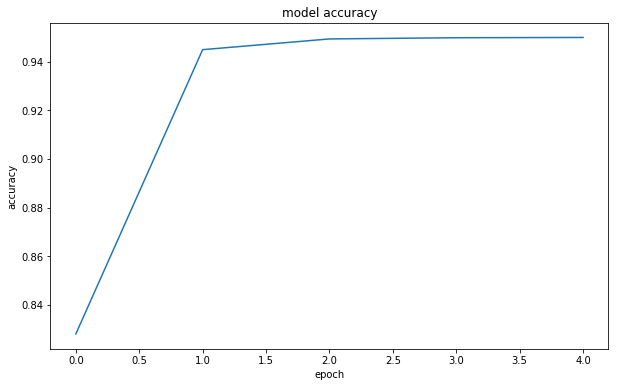

In [183]:
# 正確性の可視化
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

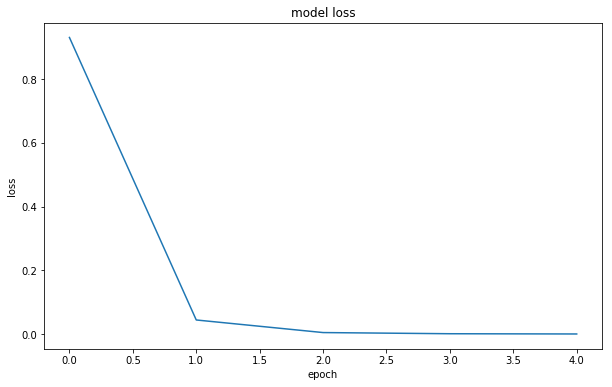

In [184]:
# 損失関数の可視化
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# モデルの読み込み
with open('seq2seq.json',"w").write(model.to_json())

# 重みの読み込み
model.load_weights('seq2seq.h5')
print("Saved Model!")

In [187]:
# 重みを保存する
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("chatbot_model.h5")
print("Saved Model!")

Saved Model!


In [191]:
json_string = model.to_json()
open('seq2seq.json', 'w').write(json_string)
model.save_weights('seq2seq_weights.h5')

In [192]:
%ls

1_0306_chatobot3.ipynb        glove.6B.50d.txt
1_0306_chatobot4.ipynb        model.json
apple_orange_model.json       movie_lines.txt
apple_orange_weights.h5       padded_decoder_sequences.txt
chatbot_model.h5              padded_encoder_sequences.txt
decoder_inputs.txt            seq2seq.json
encoder_inputs.txt            seq2seq_weights.h5


In [190]:
pwd

'/Users/akr712/Desktop/CHATBOT'